# Neural Style Transfer (Dashtoon Assignment IIT KGP)


---


**Name:** Tuhin Subhra De

**Roll:** 19CE36007


---
Dataset used: https://www.kaggle.com/datasets/duttadebadri/image-classification

Information about dataset: The dataset (size = 3 GB) contains several images belonging to categories like Travel, Food, Art and Architecture.




### Code to download the dataset to the HDD of Colab
To run this, one needs the API Key from their respective Kaggle Account. It should be named "kaggle.json" (without the qoutes) and should be present in the root directory of the notebook.

In [5]:
! pip install -q kaggle

In [9]:
! cp /content/drive/MyDrive/Colab_Notebooks/kaggle.json ~/.kaggle

In [10]:
!kaggle datasets download -d duttadebadri/image-classification

100% 2.34G/2.34G [00:27<00:00, 117MB/s]
100% 2.34G/2.34G [00:27<00:00, 91.9MB/s]


In [11]:
%%capture
!unzip /content/image-classification.zip

## Training the Base CNN Model
As style transfers requires extraction of intermediate features from the model. Hence I trained a CNN model to classifiy the dataset into four classes from scratch. Now after training we can easily access the intermediate features from the model for any of the given classes.

In [12]:
#Importing  all the necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt

from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

import copy

Data Loading and Preprocessing

In [13]:
#Data Loading
# Define the transformation to apply to the images
transform = transforms.Compose([
    transforms.Resize(256), # Resize the images to 256x256 pixels
    transforms.CenterCrop(224), # Crop the images to 224x224 pixels around the center
    transforms.ToTensor(), # Convert the images to tensors
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # Normalize the images using the mean and standard deviation of the ImageNet dataset
])

# Create a dataset object that can load the images from subfolders
dataset = datasets.ImageFolder(root='/content/images/images', transform=transform)

#splitting the dataset into train and test for training purposes
train_set, val_set = torch.utils.data.random_split(dataset,
                                            [int(0.8*len(dataset))+1, int(0.2*len(dataset))],
                                            generator=torch.Generator().manual_seed(42))

# Create a data loader object that can batch and shuffle the images
trainloader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=False)

# Iterate over the data loader and print the shape of the images and labels
for images, labels in trainloader:
    print(images.shape, images.device) # torch.Size([32, 3, 224, 224]
    print(labels.shape) # torch.Size([32])
    break

torch.Size([32, 3, 224, 224]) cpu
torch.Size([32])


Building custom CNN Model

In [14]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Convolutional layer 1:
        self.conv1 = nn.Conv2d(3, 16, 3, stride=2, padding=1)
        # Convolutional layer 2:
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        # Convolutional layer 3:
        self.conv3 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        # Fully connected layer 1:
        self.fc1 = nn.Linear(3136, 256)
        # Fully connected layer 2:
        self.fc2 = nn.Linear(256, 4)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        # Flattening the output of the last convolutional layer
        x = torch.flatten(x, 1)
        # Applying ReLU activation and dropout after the first fully connected layer
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5)
        # Applying softmax activation after the second fully connected layer
        x = F.softmax(self.fc2(x), dim=1)
        return x

Training the CNN Model

In [ ]:
from tqdm.notebook import tqdm
model = CNN()
model.to('cuda')

# loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10

for epoch in range(epochs):
    # Initialize the running loss
    print(f"Epoch: {epoch+1}")
    running_loss = 0.0
    val_running_loss = 0.0

    # Loop over the batches of data from the trainloader
    model.train()
    for inputs, labels in tqdm(trainloader):
        inputs = inputs.cuda()
        labels = labels.cuda()

        optimizer.zero_grad()
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, labels)
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        # Update the running loss
        running_loss += loss.item()

    #evaluating the model
    model.eval()
    with torch.no_grad():
        #iterating over the samples from testset
        for vinputs, vlabels in tqdm(testloader):
            vinputs = vinputs.cuda()
            vlabels = vlabels.cuda()

            val_outputs = model(vinputs)
            val_loss = criterion(val_outputs, vlabels)
            val_running_loss+=val_loss.item()
    # Printing the average loss per epoch
    print(f'loss: {running_loss / len(trainloader)}')
    print(f'Val loss: {val_running_loss / len(testloader)}')

Epoch: 1


  0%|          | 0/878 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  0%|          | 0/220 [00:00<?, ?it/s]

loss: 1.109410974322256
Val loss: 1.0257147775454956
Epoch: 2


  0%|          | 0/878 [00:00<?, ?it/s]

  0%|          | 0/220 [00:00<?, ?it/s]

loss: 0.9691585294206485
Val loss: 0.9963853245431726
Epoch: 3


  0%|          | 0/878 [00:00<?, ?it/s]

  0%|          | 0/220 [00:00<?, ?it/s]

loss: 0.9426943342072003
Val loss: 0.9670347064733505
Epoch: 4


  0%|          | 0/878 [00:00<?, ?it/s]

  0%|          | 0/220 [00:00<?, ?it/s]

loss: 0.9250045559943945
Val loss: 1.0453406090086157
Epoch: 5


  0%|          | 0/878 [00:00<?, ?it/s]

  0%|          | 0/220 [00:00<?, ?it/s]

loss: 0.9274192679851636
Val loss: 0.9175769031047821
Epoch: 6


  0%|          | 0/878 [00:00<?, ?it/s]

  0%|          | 0/220 [00:00<?, ?it/s]

loss: 0.9145170281172342
Val loss: 0.9086962117390199
Epoch: 7


  0%|          | 0/878 [00:00<?, ?it/s]

  0%|          | 0/220 [00:00<?, ?it/s]

loss: 0.9071312169958085
Val loss: 0.9184187943285161
Epoch: 8


  0%|          | 0/878 [00:00<?, ?it/s]

  0%|          | 0/220 [00:00<?, ?it/s]

loss: 0.9078123655025943
Val loss: 0.8865104607560418
Epoch: 9


  0%|          | 0/878 [00:00<?, ?it/s]

  0%|          | 0/220 [00:00<?, ?it/s]

loss: 0.909619830803339
Val loss: 0.9184887552803213
Epoch: 10


  0%|          | 0/878 [00:00<?, ?it/s]

  0%|          | 0/220 [00:00<?, ?it/s]

loss: 0.9020329455172554
Val loss: 0.8925046508962458


In [ ]:
torch.save(model, "/content/drive/MyDrive/Colab_Notebooks/entire_cnn_model.pth")

In [15]:
base_model = CNN()
base_model.load_state_dict(torch.load("/content/drive/MyDrive/Colab_Notebooks/cnn_model",
                                      map_location=torch.device('cpu')))



<All keys matched successfully>

##Style Transfer

We define two distances, one for the content Dc and one for the style Ds. Dc measures how different the content is between two images while Ds measures how different the style is between two images. Then, we take a third image, the input, and transform it to minimize both its content-distance with the content-image and its style-distance with the style-image.

**Content Representation:**
> The image is represented differently at different levels of the convolutional neural network. The deeper we go into the network, the more the representations focus on the structural features or the content of the image rather than the pixel details. We can use the feature maps of each layer to reconstruct the images and see how they are represented. The reconstruction from the lower layer will look exactly like the original image. However, the reconstruction from the higher layer will only show the high-level content and that is why we call the feature responses from the higher layer as the content representation.

**Style Representation:**

>We construct a feature space on top of each layer's filter responses to capture the style content of the input image. This feature space is based on the spatial correlations among the filter responses across the feature maps. The filter correlations at different layers reflect the texture information of the input image. This allows us to create images that match the style of a given image at different scales, while ignoring the global structure. We call this multi-scale representation the style representation.




References:




1.   https://pytorch.org/tutorials/advanced/neural_style_tutorial.html
2.   https://towardsdatascience.com/implementing-neural-style-transfer-using-pytorch-fd8d43fb7bfa



In [24]:
# desired size of the output image
device = 'cuda' if torch.cuda.is_available() else 'cpu'
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no GPU

loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


content_img = image_loader("/content/images/images/architecure/90px-BayeuxCathedral2005.jpg")
style_img = image_loader("images/images/art and culture/15 (7).jpg")

print(style_img.shape, content_img.shape)

torch.Size([1, 3, 128, 128]) torch.Size([1, 3, 128, 128])


In [ ]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [26]:
#We define the content loss as simple MSE loss between target and input
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resize F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

# We define styleloss as the mse between the gram matrix and target
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

# create a module to normalize input image so we can easily put it in a
# ``nn.Sequential``
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize ``img``
        return (img - self.mean) / self.std

In [27]:
# WE use the following features from corresponding layers of CNN for content and
# style images
content_layers_default = ['conv3']
style_layers_default = ['conv1', 'conv2', 'conv3']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std)

    # just in order to have an iterable access to or list of content/style
    # losses
    content_losses = []
    style_losses = []

    # assuming that ``cnn`` is a ``nn.Sequential``, so we make a new ``nn.Sequential``
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu{}'.format(i)
            # The in-place version doesn't play very nicely with the ``ContentLoss``
            # and ``StyleLoss`` we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn{}'.format(i)
        elif isinstance(layer, nn.Linear):
            name = 'lin{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)


    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [32]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img], lr=0.001)
    return optimizer

In [40]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=800,
                       style_weight=1e6, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    # We also put the model in evaluation mode, so that specific layers
    # such as dropout or batch normalization layers behave correctly.
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            #print(loss)
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

Final Predicting

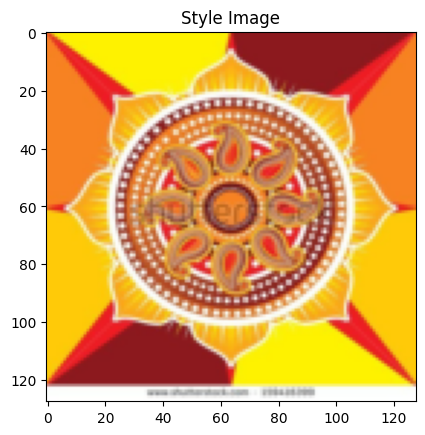

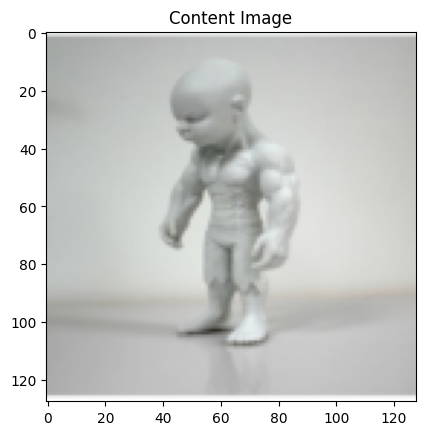

In [45]:
#Orignal input and style images
content_img = image_loader("images/images/art and culture/1 18.59.45.jpg")
style_img = image_loader("images/images/art and culture/7 (2).jpg")
input_img = image_loader("images/images/art and culture/1 18.59.45.jpg")
plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

Building the style transfer model..
Optimizing..


<ipython-input-26-caa2df1831cc>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-26-caa2df1831cc>:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


run [50]:
Style Loss : 1712786.500000 Content Loss: 10.704516

run [100]:
Style Loss : 1104723.375000 Content Loss: 28.244713

run [150]:
Style Loss : 772303.312500 Content Loss: 43.218815

run [200]:
Style Loss : 519767.750000 Content Loss: 60.127758

run [250]:
Style Loss : 346530.812500 Content Loss: 76.253677

run [300]:
Style Loss : 246547.593750 Content Loss: 87.546524

run [350]:
Style Loss : 185014.906250 Content Loss: 95.643517

run [400]:
Style Loss : 142128.250000 Content Loss: 104.168129

run [450]:
Style Loss : 116263.843750 Content Loss: 112.899010

run [500]:
Style Loss : 100771.937500 Content Loss: 119.391312

run [550]:
Style Loss : 87901.234375 Content Loss: 124.888695

run [600]:
Style Loss : 75963.093750 Content Loss: 128.318130

run [650]:
Style Loss : 65957.726562 Content Loss: 129.721252

run [700]:
Style Loss : 58255.054688 Content Loss: 129.547318

run [750]:
Style Loss : 51080.957031 Content Loss: 128.761917

run [800]:
Style Loss : 44892.402344 Content Loss: 

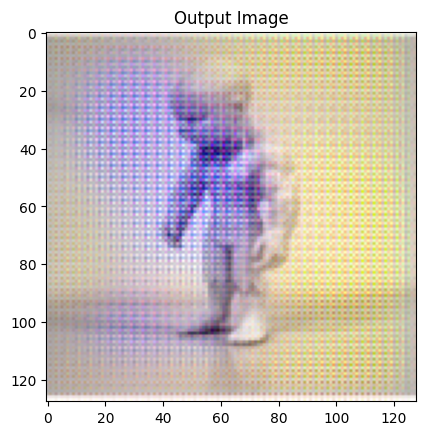

In [46]:

output = run_style_transfer(base_model, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

**Observations:**

We observe that there is a slight style transfer between the images. It is not much prominent. This can be due to that fact of limited capacity of base CNN model. This can be improved by fine training the base model and increasing the number of convolutional layers for much better feature extraction.